## 2020707035_박시언 	homework #7: text processing - classification

카테고리는 rec.sport.hockey sci.med comp.graphics talk.politics.mideast를 사용했습니다.  
step1. 불용어를 처리했습니다. 이후에 punctuation 문자를 제거했습니다.  
step2. DTM을 만들었습니다. 이는 tf만 반영된 metrix입니다.  
step3. DTM에서 tf-idf를 이용하여 빈도에 대한 값 조정을 했습니다.  
step4. word2vec을 이용해서 단어를 벡터로 바꿉니다. 단, 이는 단어에 한해서 vector로 바꿔주기에 하나의 document에는 여러 벡터가 있을것이고 이를 하나의 벡터로 인베딩 시키기 위해 각각의 토큰의 임베딩 벡터를 평균을 내어 하나의 문장을 256차원의 벡터로 표현했습니다.  
step5. glove_embedding도 토큰별 벡터만 반환하기에 step4와 같은 과정을 거쳤습니다.  
step6. 각각 문장의 벡터 표현을 LogisticRegression과 NaiveBayes에 넣어 성능을 비교했습니다.  

## 결과

Evaluating Document-Term Matrix...  
DTM (LogisticRegression) - Accuracy: 0.8694, F1 Score: 0.8703, ROC/AUC: 0.9824  
DTM (NaiveBayes) - Accuracy: 0.9014, F1 Score: 0.9015, ROC/AUC: nan  

Evaluating TF-IDF Matrix...  
TF-IDF (LogisticRegression) - Accuracy: 0.8976, F1 Score: 0.8985, ROC/AUC: 0.9896  
TF-IDF (NaiveBayes) - Accuracy: 0.9078, F1 Score: 0.9079, ROC/AUC: nan  

Evaluating Word2Vec Embedding...  
Word2Vec (LogisticRegression) - Accuracy: 0.902 , F1 Score: 0.9032, ROC/AUC: 0.9896  

Evaluating Pre-Trained GloVe Embedding...  
GloVe (LogisticRegression) - Accuracy: 0.8476, F1 Score: 0.8488, ROC/AUC: 0.9658  

모든 점수에서 word2vec이 우수하고 이후로는 TF-IDF = DTM 이 두 개의 토큰 표현이이 거의 동일한 성능으로 나타났습니다. GloVe는 가장 안좋은 성능을 기록했습니다.  

Evaluating Document-Term Matrix...
DTM (LogisticRegression) - Accuracy: 0.8694, F1 Score: 0.8703, ROC/AUC: 0.9824
DTM (NaiveBayes) - Accuracy: 0.9014, F1 Score: 0.9015, ROC/AUC: nan

Evaluating TF-IDF Matrix...
TF-IDF (LogisticRegression) - Accuracy: 0.8976, F1 Score: 0.8985, ROC/AUC: 0.9896
TF-IDF (NaiveBayes) - Accuracy: 0.9078, F1 Score: 0.9079, ROC/AUC: nan

Evaluating Word2Vec Embedding...
Word2Vec (LogisticRegression) - Accuracy: 0.9065, F1 Score: 0.9072, ROC/AUC: 0.9898

Evaluating Pre-Trained GloVe Embedding...
GloVe (LogisticRegression) - Accuracy: 0.8476, F1 Score: 0.8488, ROC/AUC: 0.9658


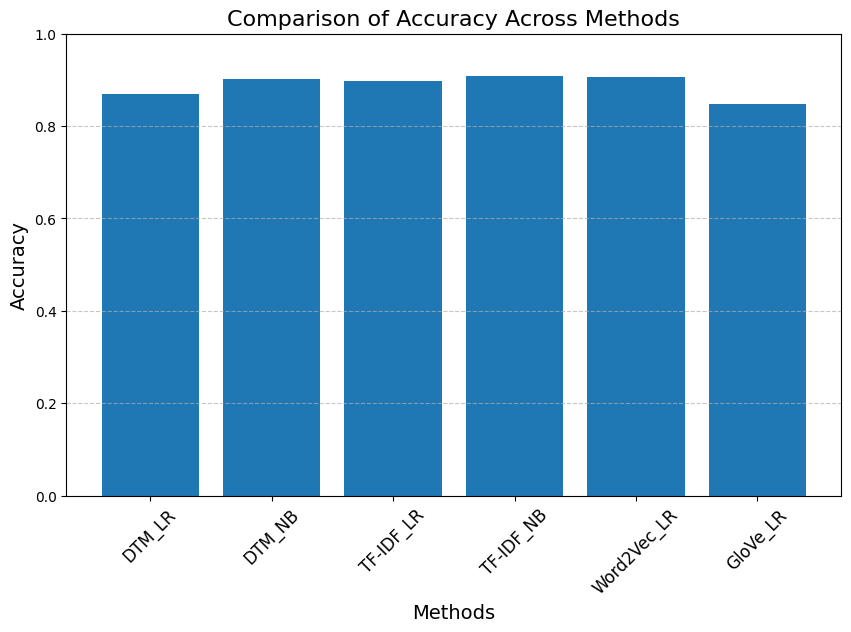

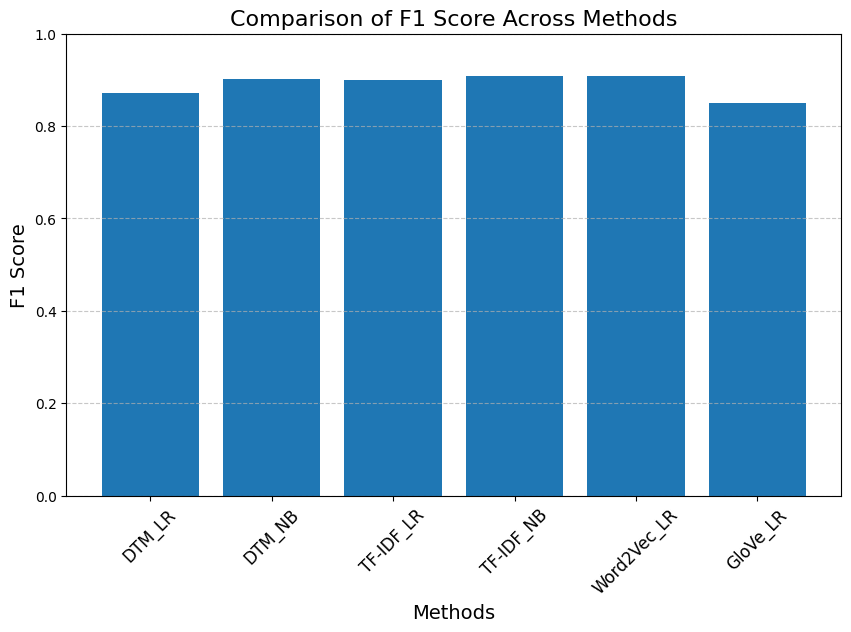

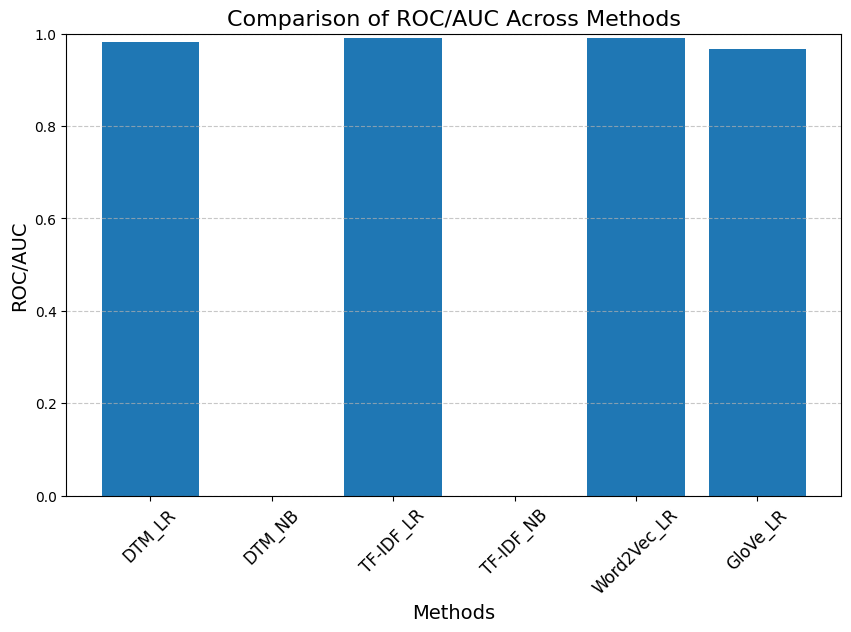

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import string
import warnings


warnings.filterwarnings("ignore")

# 1. 데이터 로드
categories = ['rec.sport.hockey', 'sci.med', 'comp.graphics', 'talk.politics.mideast']  # 선택된 카테고리
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.2, random_state=42)

# 2. 불용어 및 구두점 제거 함수
def preprocess_text(texts):
    stop_words = set(ENGLISH_STOP_WORDS)  # 불용어 리스트
    processed_texts = []
    for text in texts:
        # 소문자로 변환
        text = text.lower()
        # 구두점 제거
        text = text.translate(str.maketrans('', '', string.punctuation))
        # 불용어 제거
        text = " ".join(word for word in text.split() if word not in stop_words)
        processed_texts.append(text)
    return processed_texts

# 전처리 적용
X_train = preprocess_text(X_train)
X_test = preprocess_text(X_test)

# 3. Document-Term Matrix
def document_term_matrix(X_train, X_test):
    vectorizer = CountVectorizer(max_features=5000)  # 상위 5000개 단어 사용
    X_train_dtm = vectorizer.fit_transform(X_train).toarray()
    X_test_dtm = vectorizer.transform(X_test).toarray()
    return X_train_dtm, X_test_dtm

# 4. TF-IDF Matrix
def tfidf_matrix(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()
    return X_train_tfidf, X_test_tfidf

# 5. Word2Vec 임베딩
def word2vec_embedding_optimized(X_train, X_test):
    X_train_tokens = [text.split() for text in X_train]
    X_test_tokens = [text.split() for text in X_test]
    
    # Word2Vec 모델
    model = Word2Vec(
        sentences=X_train_tokens,
        vector_size=256,   # 벡터 크기 증가
        window=10,         # 넓은 컨텍스트
        min_count=2,       # 최소 단어 빈도 증가
        workers=10,
        sg=1,              # Skip-Gram 사용
        epochs=10          # 학습 반복 증가
    )
    
    # 평균 임베딩 계산
    def get_avg_embedding(tokens, model):
        embeddings = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)
    
    X_train_w2v = np.array([get_avg_embedding(tokens, model) for tokens in X_train_tokens])
    X_test_w2v = np.array([get_avg_embedding(tokens, model) for tokens in X_test_tokens])
    
    return X_train_w2v, X_test_w2v

# 6. Pre-Trained GloVe 임베딩
def glove_embedding(X_train, X_test, glove_path='glove.twitter.27B.25d.txt'):
    # GloVe 벡터 로드
    glove = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
    # 토큰화
    X_train_tokens = [text.split() for text in X_train]
    X_test_tokens = [text.split() for text in X_test]
    # 평균 임베딩 계산
    def get_avg_embedding(tokens, glove):
        embeddings = [glove[word] for word in tokens if word in glove]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(glove.vector_size)
    X_train_glove = np.array([get_avg_embedding(tokens, glove) for tokens in X_train_tokens])
    X_test_glove = np.array([get_avg_embedding(tokens, glove) for tokens in X_test_tokens])
    return X_train_glove, X_test_glove

# 7. 모델 학습 및 성능 평가
def evaluate_model(X_train, X_test, y_train, y_test, method_name, model_type="LogisticRegression"):
    if model_type == "LogisticRegression":
        model = LogisticRegression(max_iter=500)
    elif model_type == "NaiveBayes":
        model = MultinomialNB()
    else:
        raise ValueError("Unsupported model type")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if model_type == "LogisticRegression":
        y_prob = model.predict_proba(X_test)  # 클래스별 확률 분포
        try:
            auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        except ValueError:
            auc = float('nan')  # AUC 계산이 실패하면 NaN
    else:
        auc = float('nan')  # Naive Bayes는 확률 기반 계산 없이 생략
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{method_name} ({model_type}) - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, ROC/AUC: {auc:.4f}")
    return acc, f1, auc

# 성능 저장용 리스트
results = []

# 8. 각 방법별로 실행 및 성능 저장
print("Evaluating Document-Term Matrix...")
X_train_dtm, X_test_dtm = document_term_matrix(X_train, X_test)
results.append(("DTM_LR", *evaluate_model(X_train_dtm, X_test_dtm, y_train, y_test, "DTM", "LogisticRegression")))
results.append(("DTM_NB", *evaluate_model(X_train_dtm, X_test_dtm, y_train, y_test, "DTM", "NaiveBayes")))

print("\nEvaluating TF-IDF Matrix...")
X_train_tfidf, X_test_tfidf = tfidf_matrix(X_train, X_test)
results.append(("TF-IDF_LR", *evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF", "LogisticRegression")))
results.append(("TF-IDF_NB", *evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF", "NaiveBayes")))

print("\nEvaluating Word2Vec Embedding...")
X_train_w2v, X_test_w2v = word2vec_embedding_optimized(X_train, X_test)
results.append(("Word2Vec_LR", *evaluate_model(X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec", "LogisticRegression")))

print("\nEvaluating Pre-Trained GloVe Embedding...")
glove_path = '/media/unsi/media/data/glove.twitter.27B.25d.txt'  # 실제 파일 경로
X_train_glove, X_test_glove = glove_embedding(X_train, X_test, glove_path)
results.append(("GloVe_LR", *evaluate_model(X_train_glove, X_test_glove, y_train, y_test, "GloVe", "LogisticRegression")))

# 9. 시각화 코드 추가
# 결과를 분리
methods, accuracies, f1_scores, aucs = zip(*results)

# Accuracy, F1 Score, ROC/AUC 비교를 위한 막대 그래프
metrics = ["Accuracy", "F1 Score", "ROC/AUC"]
values = [accuracies, f1_scores, aucs]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    plt.bar(methods, values[i])
    plt.title(f"Comparison of {metric} Across Methods", fontsize=16)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("Methods", fontsize=14)
    plt.ylim(0, 1)  # 모든 점수가 0~1 사이이므로 y축 고정
    plt.xticks(rotation=45, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4090'